In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import metrics
from numpy import sqrt, argmax

In [2]:
###Import of files
testing_dataset = pd.read_csv("testing_dataset_sex.csv", sep=",")
merged_df = pd.read_csv("detections_testing_sex.csv", sep=",")

merged_df['date'] = pd.to_datetime(merged_df['date'], format="%Y-%m-%d %H:%M:%S")

In [3]:
### Building of vectors (input of CNN models)

out = []
rfid_year_list = pd.DataFrame()
out3 = []
for start_year in range(1998, 2023):
    start_date = datetime.datetime(year=start_year-1, month=9, day=1)
    end_date = start_date + timedelta(days=517)
    dRange = pd.date_range(start=start_date, end=end_date, freq="12H")
    # perform the grid search on time/rfid values
    values = merged_df[merged_df["year"] == start_year].groupby([pd.Grouper(key="date", freq="12H"), "rfid"])["antenna"].last().unstack().reindex(dRange).fillna(method="ffill").fillna(False).astype(int).values
    values_detect_number = merged_df[merged_df["year"] == start_year].groupby([pd.Grouper(key="date", freq="12H"), "rfid"])["antenna"].size().unstack().reindex(dRange).fillna(value=0).astype(int).values
    rfid_year = merged_df[merged_df["year"] == start_year][["rfid","year"]]
    # look for the corresponding breeding labels for this season
    out.extend(values.T)
    out3.extend(values_detect_number.T)
    if not rfid_year.empty:
        rfid_year_list = pd.concat([rfid_year_list, pd.DataFrame(rfid_year.drop_duplicates())])
        
final_value = [[0] for x in range(len(out))]
val = [[0,0] for x in range(975)]
for i in range(len(out)):
    for j in range(975):
        val[j] = [out[i][j+58],out3[i][j+58]]
    final_value[i]= np.array(val)
    
### Smaller vectors for determination of the sex    
final_value_425 = [i[0:425] for i in final_value]

In [4]:
###Import of models

model_M_F = keras.models.load_model('models/model_determination_M_F')
model_NB_B = keras.models.load_model('models/model_determination_B_NB')

In [5]:
### Predictions with the models

classif_M_F = model_M_F.predict(np.array(final_value_425))
classif_NB_B = model_NB_B.predict(np.array(final_value))
prediction_M_F = np.argmax(classif_M_F, axis=-1)
prediction_NB_B = np.argmax(classif_NB_B, axis=-1)
data_MF = pd.DataFrame(classif_M_F, columns=["F", "M"])

data = pd.DataFrame({'rfid': rfid_year_list["rfid"], 'year': rfid_year_list["year"], 'pred_M_F': prediction_M_F, 'pred_NB_B': prediction_NB_B})
data.reset_index(inplace=True, drop=True)
data['pred_M_F'] = data['pred_M_F'].replace(1, "M")
data['pred_M_F'] = data['pred_M_F'].replace(0, "F")

data['pred_NB_B'] = data['pred_NB_B'].replace(0, "NB")
data['pred_NB_B'] = data['pred_NB_B'].replace(1, "B")

data = pd.merge(data, data_MF, left_index=True, right_index=True)

### lifetime sex determination
sex_list = []
n_B_list=[]
data_temp = data.loc[data["pred_NB_B"] == "B"]
data_grouped = data_temp.groupby('rfid')
data_sex = data_grouped.mean()[['F', 'M']]
data_sex['sex_predict'] = data_sex.idxmax(axis=1)
data_sex['number_breeding'] = data_grouped.count()['year']

In [6]:
### Global accuracy of sex determination over lifetime breeding seasons
testing_dataset = pd.merge(testing_dataset, data_sex.loc[data_sex["sex_predict"] != "I"], on='rfid')

print('Global accuracy of sex determination: ')
print(len(testing_dataset.loc[testing_dataset["sexe"] == testing_dataset["sex_predict"]])/len(testing_dataset))

Global accuracy of sex determination: 
0.8865731462925852


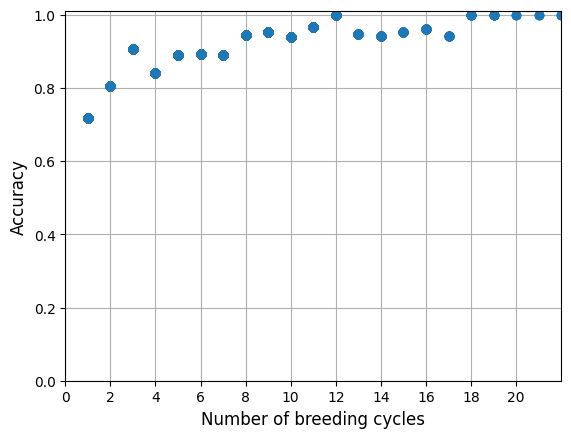

In [7]:
### Plot of sex determination accuracy according to the number of used breeding
number_breeding = [int(x) for x in testing_dataset["number_breeding"] if pd.notna(x)]
acc_age_spe_sex = []
for i in number_breeding:
    temp_df = (testing_dataset.loc[testing_dataset["number_breeding"] == i])
    acc_age_spe_sex.append(sum(temp_df["sexe"] == temp_df["sex_predict"]) / len(temp_df))

plt.figure()
plt.plot(number_breeding,acc_age_spe_sex,'o')
plt.axis([0, max(number_breeding) , 0, 1.01])
plt.xticks([x*2 for x in range(11)])
plt.xlabel('Number of breeding cycles', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.grid(True)
# plt.savefig('accuracy_graph_sex.png', dpi=500, bbox_inches='tight', transparent= True)

In [8]:
### Global accuracy of sex determination without pooling method 

sex_genet = pd.read_csv("testing_dataset_sex.csv", sep=",")
sex_by_cycle = data.merge(sex_genet, on='rfid')
sex_by_cycle = sex_by_cycle.loc[sex_by_cycle['pred_NB_B'] == 'B']
print('Global accuracy of sex determination without pooling method: ')
print(len(sex_by_cycle.loc[sex_by_cycle["pred_M_F"] == sex_by_cycle["sexe"]])/len(sex_by_cycle))

Global accuracy of sex determination without pooling method: 
0.8181503090520479


AUC score: 0.930719487411451
Best Threshold=0.648743, G-Mean=0.903


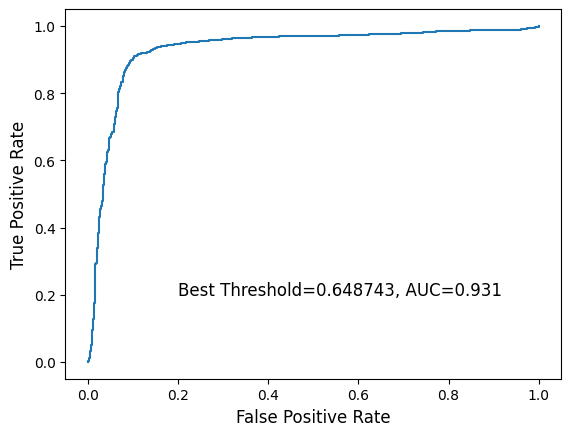

In [9]:
###AUC score for sex determination

testing_dataset['sexe'] = testing_dataset['sexe'].replace('M', 1)
testing_dataset['sexe'] = testing_dataset['sexe'].replace('F', 0)

fpr, tpr, thresholds = metrics.roc_curve(testing_dataset['sexe'], testing_dataset['M'])

auc = metrics.roc_auc_score(testing_dataset['sexe'],  testing_dataset['M'])
print("AUC score: " + str(auc))
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.text(0.2, 0.2, 'Best Threshold=%f, AUC=%.3f' % (thresholds[ix], auc), fontsize = 12)
# plt.savefig('AUC_sex_genetic.png', dpi=500, bbox_inches='tight')

plt.show()